In [1]:
import coffea
from coffea.nanoevents.methods import vector
import coffea.hist as hist
import uproot
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import sys,os

# from pyjet import cluster
import awkward as ak

from sklearn.cluster import DBSCAN

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema,BaseSchema

sys.path.append(os.getcwd().replace('scripts', 'lib'))
import util

from numba import jit

# Open data files

 * First file contains collision data taken with zerobias trigger in 2018, i.e. events recorded are mostly pile-up events. We selected those events with cluster-like signature in this nTuple. 
 * The 2nd file contains signal simulation with $H\rightarrow SS \rightarrow 4b$ events

In [24]:
fpath = "~/eos/llp/zerobias18/displacedJetMuon_ntupler.root"
# fpath = "root://cmsxrootd.fnal.gov//store/group/phys_exotica/delayedjets/displacedJetMuonNtuple/V1p17/One_Lepton_Merged_MS_Hits/SingleElectron/2017B/merged_AOD121.root"
data = NanoEventsFactory.from_root(fpath,
                                   schemaclass=BaseSchema,
                                   treepath="ntuples/llp"
                                  ).events()
fpath ="/uscms/home/kkwok/eos/llp/ggH_HToSSTobbbb_MH-125_TuneCP5_13TeV-powheg-pythia8/displacedJetMuon_ntupler_1.root"

signal = NanoEventsFactory.from_root(fpath,
                                   schemaclass=BaseSchema,
                                   treepath="ntuples/llp"
                                  ).events()

## The tree is loaded with the "coffea" analysis framework
The events are loaded into an "awkward arrays", i.e. arrays with irregular sizes
Our event-based data fits into awkward arrays very naturally!
 - Tree:
 -  |-muonPt :[ [Pt1,Pt2], [Pt1] ...]
 -  |-muonEta:[ [Eta1,Eta2], [Eta1] ...]

In [25]:
signal

<NanoEventsArray [{isData: False, nPV: 20, ... -666]}] type='20000 * event'>

In [26]:
# this awkward array has 2546 events, of the type "event"
data

<NanoEventsArray [{isData: True, nPV: -1, ... ] type='2546 * event'>

In [27]:
# shows the branches of the tree
data.fields

['isData',
 'nPV',
 'runNum',
 'nSlimmedSecondV',
 'lumiNum',
 'eventNum',
 'eventTime',
 'pvX',
 'pvY',
 'pvZ',
 'fixedGridRhoAll',
 'fixedGridRhoFastjetAll',
 'fixedGridRhoFastjetAllCalo',
 'fixedGridRhoFastjetCentralCalo',
 'fixedGridRhoFastjetCentralChargedPileUp',
 'fixedGridRhoFastjetCentralNeutral',
 'nCscWireDigis',
 'nCscStripDigis',
 'nCscSeg',
 'cscSegPhi',
 'cscSegEta',
 'cscSegX',
 'cscSegY',
 'cscSegZ',
 'cscSegT',
 'cscSegChi2',
 'cscSegChamber',
 'cscSegStation',
 'cscSegNRecHits',
 'ncscRechits',
 'cscRechitsPhi',
 'cscRechitsEta',
 'cscRechitsX',
 'cscRechitsY',
 'cscRechitsZ',
 'cscRechitsE',
 'cscRechitsTpeak',
 'cscRechitsTwire',
 'cscRechitsQuality',
 'cscRechitsChamber',
 'cscRechitsStation',
 'cscRechitsClusterId',
 'cscRechitsChannels',
 'cscRechitsNStrips',
 'cscRechitsHitWire',
 'cscRechitsWGroupsBX',
 'cscRechitsNWireGroups',
 'cscRechitsDetId',
 'nCscRechitClusters',
 'cscRechitCluster_match_cscSegCluster_minDeltaR',
 'cscRechitCluster_match_cscSegCluster_i

## Accessing a branch like this will give the data in the format of (awkward)arrays
 - Note that the type becomes "int32"
 - For event-level quantity (number of total rechits),
   the length of array is the **same** as the number of events

In [28]:
data.ncscRechits

<Array [0, 19, 264, 62, ... 21, 391, 247, 206] type='2546 * int32[parameters={"_...'>

 - For object-level quantity (X pos. of each rechit), the first dimension of array is the same as the number of events, but the 2nd dimension of the array is **variable (var, float32)** 

In [29]:
data.cscRechitsX

<Array [[], [-448, -450, ... 140, 104, 142]] type='2546 * var * float32[paramete...'>

## Pack all the rechit properties arrays in 1 object

In [9]:
def pack(events,obj_str):
    obj  = ak.zip(
                {k.replace(obj_str,""):getattr(events,k) for k in events.fields if k.startswith(obj_str)}
                ,with_name="PtEtaPhiMLorentzVector",
                behavior=vector.behavior
               )
    return obj

In [30]:
d_rechits = pack(data,"cscRechits")

In [31]:
s_rechits = pack(signal,"cscRechits")

 - These properties mostly follow from the CMSSW definition: [here](https://github.com/cms-sw/cmssw/blob/master/DataFormats/CSCRecHit/interface/CSCRecHit2D.h)
 - Our nTuplizer only dropped a few properties and computed a few new ones
 - We will use the following properties:
   - Eta,Phi
   - X,Y,Z
   - Tpeak (Time calculated from strip input), Twire (Time calculated from wire input) [src code](https://github.com/cms-sw/cmssw/blob/master/RecoLocalMuon/CSCRecHitD/src/CSCMake2DRecHit.cc)
   - Station

In [17]:
d_rechits.fields

['Phi',
 'Eta',
 'X',
 'Y',
 'Z',
 'E',
 'Tpeak',
 'Twire',
 'Quality',
 'Chamber',
 'Station',
 'ClusterId',
 'Channels',
 'NStrips',
 'HitWire',
 'WGroupsBX',
 'NWireGroups',
 'DetId']

In [36]:
np.unique(ak.flatten(abs(d_rechits.Chamber)))

<Array [11, 12, 13, 21, 22, 31, 32, 41, 42] type='9 * int32'>

In [24]:
# Check number of rechits
ak.num(rechits)

<Array [0, 19, 264, 62, ... 21, 391, 247, 206] type='2546 * int64'>

## Look at the 2D event display of rechits

In [32]:
def displayRZ(i_event,rechits=[],cls=[]):
    plt.style.use(hep.style.CMS) 
    
    #Select the rechits in the i-th event
    i_rh = rechits[i_event] if len(rechits)>0 else None
    i_cls = cls[i_event] if len(cls)>0 else None
    
    #Make a figure with 2 subplots
    fig, axs = plt.subplots(1,2, figsize=(18,8))

    axs = axs.flatten()
    #plot clusters:
    if len(cls)>0:
        #Eta-phi plot:        
        s1=axs[0].scatter(i_cls.Eta,i_cls.Phi,s=i_cls.Nhit,label="Cluster")
        for cl in i_cls:
            cone = plt.Circle((cl.Eta, cl.Phi), 0.4, color='b', fill=False,)
            axs[0].add_patch(cone)        
        
        #R-Z plot:        
        cls_r = (i_cls.X**2+i_cls.Y**2)**0.5        
        axs[1].scatter(np.abs(i_cls.Z),cls_r,s=i_cls.Nhit)            
    
    #plot rechits:
    if len(rechits)>0:
        #Eta-phi plot:
        s2=axs[0].scatter(i_rh.Eta,i_rh.Phi,s=1,label="Rechits")
        rh_r = (i_rh.X**2+i_rh.Y**2)**0.5    
        
        #R-Z plot:        
        axs[1].scatter(np.abs(i_rh.Z),rh_r,s=1)

    #label eta-phi plot
    axs[0].text(0.1,0.9,"%s-th event"%i_event,transform=axs[0].transAxes)
    axs[0].set_ylim(-np.pi,np.pi)
    axs[0].set_xlim(-5,5)
    axs[0].set_ylabel(r"$\phi$")
    axs[0].set_xlabel(r"$\eta$")
    
    #label RZ plot
    MB_xmin = 300
    util.drawRZ(axs[1],MB_xmin)
    axs[1].set_xlim(MB_xmin,None)
    axs[1].set_xlabel("|z|[cm]")
    axs[1].set_ylabel("R[cm]")
    
    #make legend
    handles, labels = [(a + b) for a, b in zip(axs[0].get_legend_handles_labels(), 
                                           axs[1].get_legend_handles_labels())]
    leg=fig.legend(handles, labels,
                   bbox_to_anchor=(1.0, 1.0), loc='upper left')   
    for ax in axs:
        hep.cms.label(ax=ax,data=True,label="Preliminary")    
    for l in leg.legendHandles:
        l._sizes = [30]
    plt.tight_layout()
    return

### Try to look at the rechits from different events!

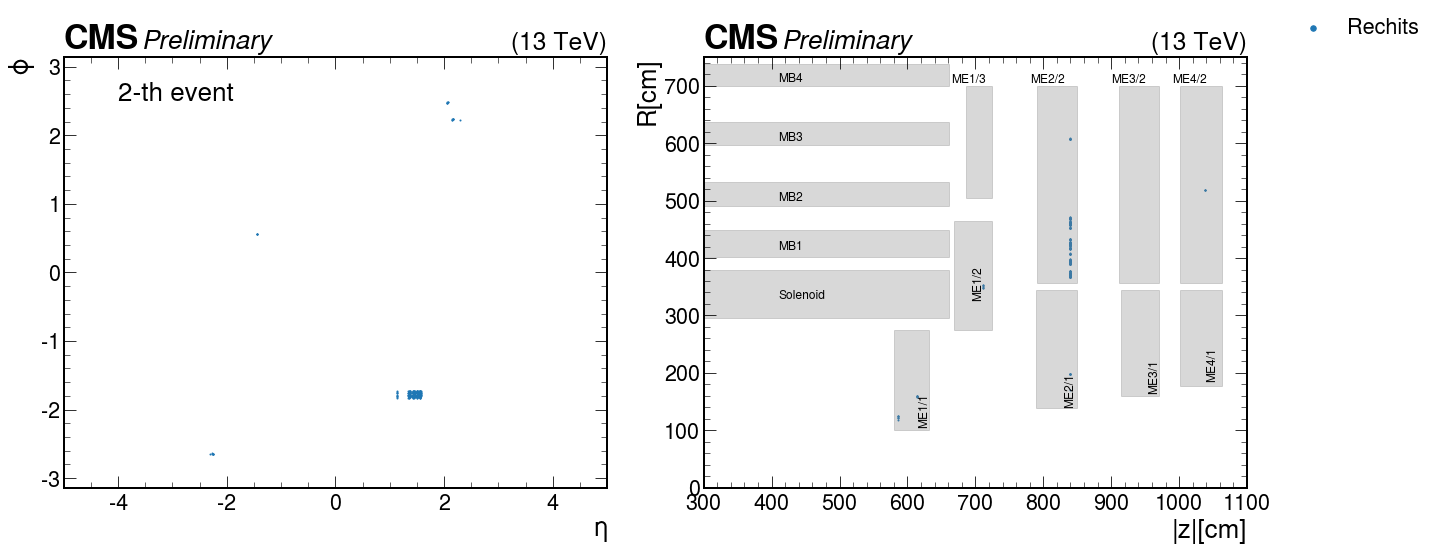

In [65]:
displayRZ(2,rechits)

# Clustering the rechits

 We are using DBSCAN algorithm, implemented with the python lib: `sklearn.cluster`

In [42]:
def DBScan(rechits,nCore,eps):
    points=ak.zip([rechits.Eta,rechits.Phi],highlevel=False)

    all_clusters = []
    for x,rechit in zip(points,rechits):
        n_clusters_=0
        core_samples_mask=[]
        ## format into DBSCAN input format x=[ [x1,y1],[x2,y2] ... ]        
        x=np.stack(ak.unzip(x),axis=1)
        i_clusters = []        
        if len(x)>0:            
            db = DBSCAN(eps=eps, min_samples=nCore).fit(x)
            core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
            core_samples_mask[db.core_sample_indices_] = True
            labels = db.labels_    
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            
            ## Loop over clusters in this event
            for iCs in range(n_clusters_):

                #Compute each cluster's properties:
                #    Input = rechits that belongs to this cluster (done via array masking)
                cls = computeCluster(rechit[labels==iCs])
                i_clusters.append(cls)
        all_clusters.append(i_clusters)
    return ak.Array(all_clusters)

def computeCluster(rechits):
    cls = {}

    cls["Nhit"] = len(rechits)
    cls["Eta"] = np.mean(rechits.Eta)
    cls["Phi"] = np.mean(rechits.Phi)
    cls["X"] = np.mean(rechits.X)
    cls["Y"] = np.mean(rechits.Y)    
    cls["Z"] = np.mean(rechits.Z)        
    cls["Time"]= np.mean(rechits.Tpeak + rechits.Twire)

    avgStation10,nStation10 = computeStationProp(rechits)
    nME11_12 = computeME11_12(rechits)
    
    cls["nStation10"] = nStation10
    cls['avgStation10'] = avgStation10
    cls["nME11_12"] = nME11_12
    
    return cls

def computeStationProp(rechits):
#     uniqueStations = np.unique(rechits.Station)    
    uniqueStations = np.array([-4,-3,-2,-1,1,2,3,4])    
    nStation10   = 0
    avgStation10 = 0
    TotHitsStation10 = 0
    for i_station in uniqueStations:
        nRechit_in_i_station = sum(rechits.Station==i_station)
        if nRechit_in_i_station >=10:
            nStation10 +=1
            avgStation10 += i_station * nRechit_in_i_station
            TotHitsStation10 += nRechit_in_i_station
    avgStation10 = avgStation10/TotHitsStation10
    return avgStation10,nStation10

def computeME11_12(rechits):
    return ak.sum((abs(rechits.Chamber)==11)|(abs(rechits.Chamber)==12))
    

In [37]:
d_rechits.fields

['Phi',
 'Eta',
 'X',
 'Y',
 'Z',
 'E',
 'Tpeak',
 'Twire',
 'Quality',
 'Chamber',
 'Station',
 'ClusterId',
 'Channels',
 'NStrips',
 'HitWire',
 'WGroupsBX',
 'NWireGroups',
 'DetId']

In [43]:
%%time

minPoint = 50
dR = 0.2
d_cls = DBScan(d_rechits,minPoint,dR)

CPU times: user 1min 17s, sys: 2 s, total: 1min 19s
Wall time: 1min 19s


In [48]:
%%time
s_cls = DBScan(s_rechits,minPoint,dR)

CPU times: user 2min 4s, sys: 197 ms, total: 2min 4s
Wall time: 2min 4s


In [10]:
cls.fields

['Nhit', 'Eta', 'Phi', 'X', 'Y', 'Z', 'Time', 'nStation10', 'avgStation10']

## Try to see if the cluster in the previous event makes sense!

In [ ]:
displayRZ(2,rechits,cls)

# Examine cluster properties

In [12]:
samples=[
    {"cls":cls,"label":"data"}, 
]
density=False

In [50]:
samples=[
    {"cls":d_cls,"label":"data"}, 
    {"cls":s_cls,"label":"signal"},     
]
density=True

## Number of clusters and N_rechits

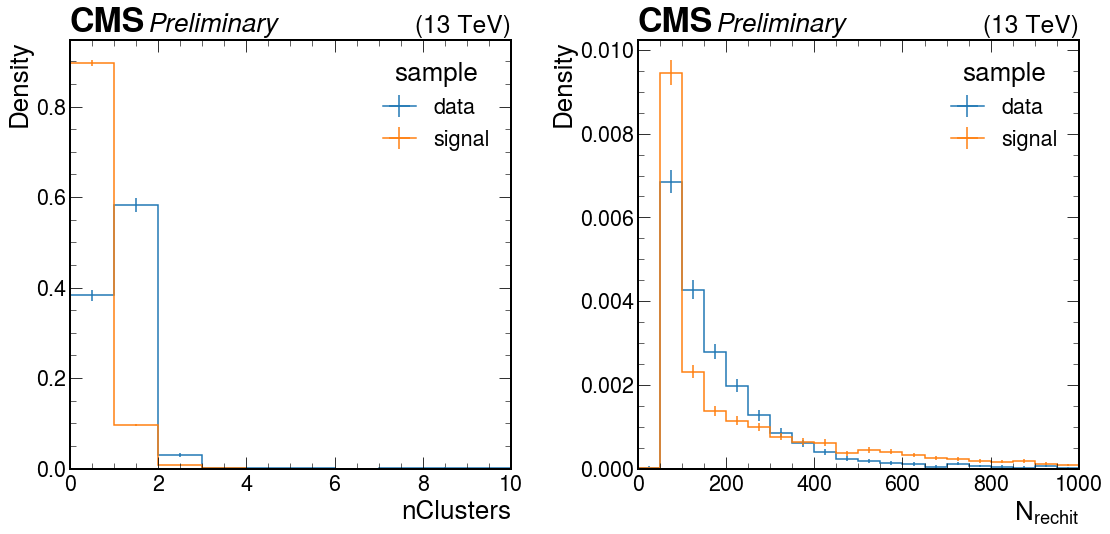

In [51]:
plt.style.use(hep.style.CMS)  
fig, axs = plt.subplots(1,2,figsize=(16,8))

axs = axs.flatten()
h1= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("nClusters", "nClusters", 10, 0, 10))
h2= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("Nhit", r"$N_{rechit}$", 20, 0, 1000))

for sample in samples:
    cls = sample['cls']
    label = sample['label']
    h1.fill(sample=label ,nClusters=ak.num(cls))
    h2.fill(sample=label ,Nhit = ak.flatten(cls.Nhit))

hist.plot1d(h1,density=density,ax=axs[0])    
hist.plot1d(h2,density=density,ax=axs[1])
for ax in axs:
    
    hep.cms.label(ax=ax,data=True,label="Preliminary")        
    if density: ax.set_ylabel("Density")
plt.tight_layout()


# Cluster position distributions (Eta,Phi,X,Y,Z )

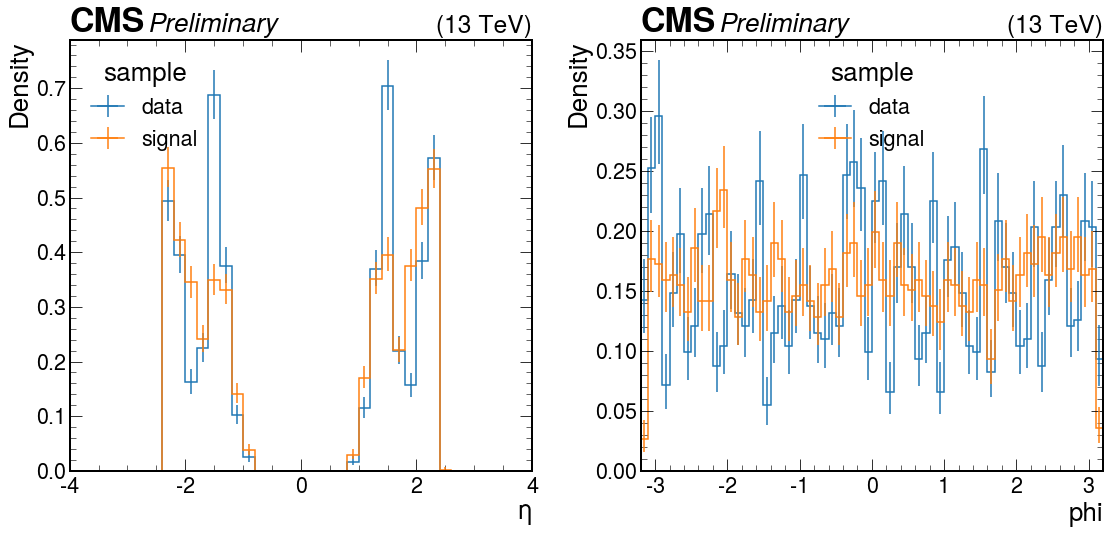

In [52]:
plt.style.use(hep.style.CMS)  
fig, axs = plt.subplots(1,2,figsize=(16,8))

axs = axs.flatten()
h1= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("eta", r"$\eta$", 40, -4, 4))
h2= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("phi", "phi", 64, -3.2, 3.2))

for sample in samples:
    cls = sample['cls']
    label = sample['label']
    h1.fill(sample=label ,eta = ak.flatten(cls.Eta))
    h2.fill(sample=label ,phi = ak.flatten(cls.Phi))

hist.plot1d(h1,density=density,ax=axs[0])    
hist.plot1d(h2,density=density,ax=axs[1])
for ax in axs:
    
    hep.cms.label(ax=ax,data=True,label="Preliminary")        
    if density: ax.set_ylabel("Density")
plt.tight_layout()


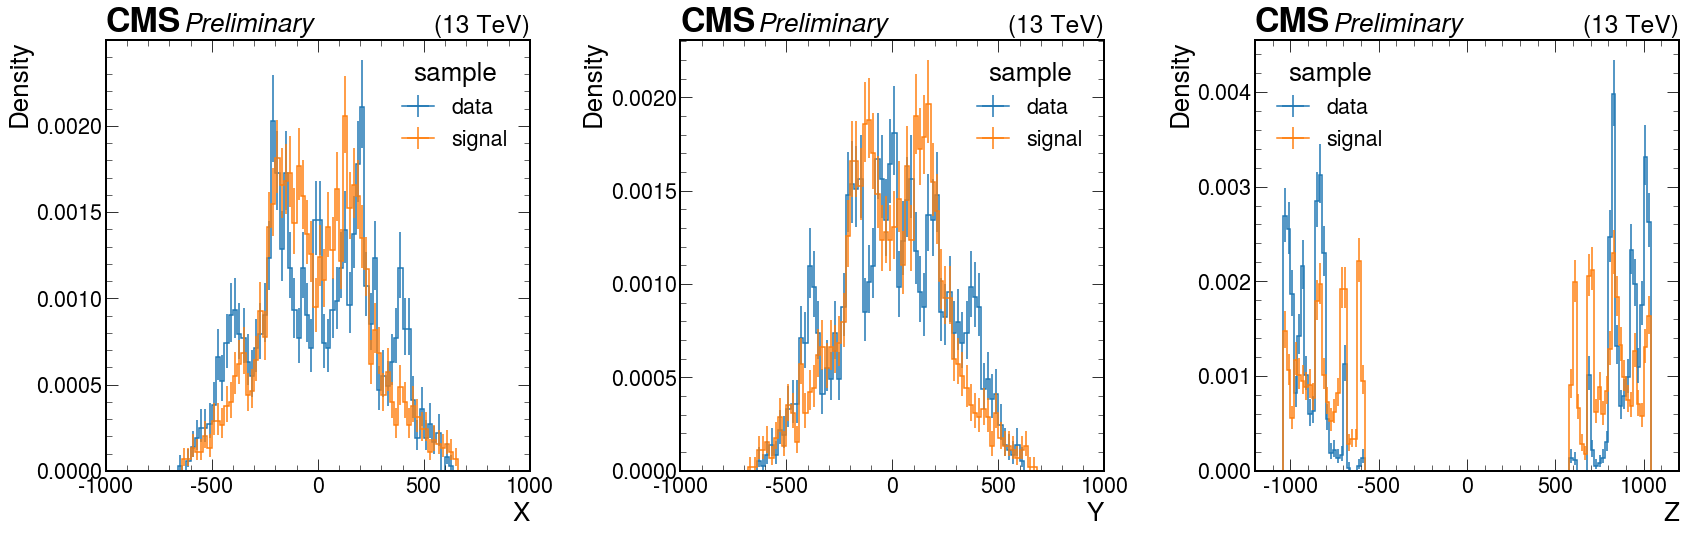

In [53]:
plt.style.use(hep.style.CMS)  
fig, axs = plt.subplots(1,3,figsize=(24,8))

axs = axs.flatten()
h1 = hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("X", "X", 100, -1000, 1000))        
h2 = hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("Y", "Y", 100, -1000, 1000))        
h3 = hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("Z", "Z", 120, -1200, 1200))            

for sample in samples:
    cls = sample['cls']
    label = sample['label']
    h1.fill(sample=label ,X = ak.flatten(cls.X))
    h2.fill(sample=label ,Y = ak.flatten(cls.Y))
    h3.fill(sample=label ,Z = ak.flatten(cls.Z))    
    

hist.plot1d(h1,density=density,ax=axs[0])    
hist.plot1d(h2,density=density,ax=axs[1])
hist.plot1d(h3,density=density,ax=axs[2])
for ax in axs:
    
    hep.cms.label(ax=ax,data=True,label="Preliminary")        
    if density: ax.set_ylabel("Density")
plt.tight_layout()


# Cluster properties for background rejection

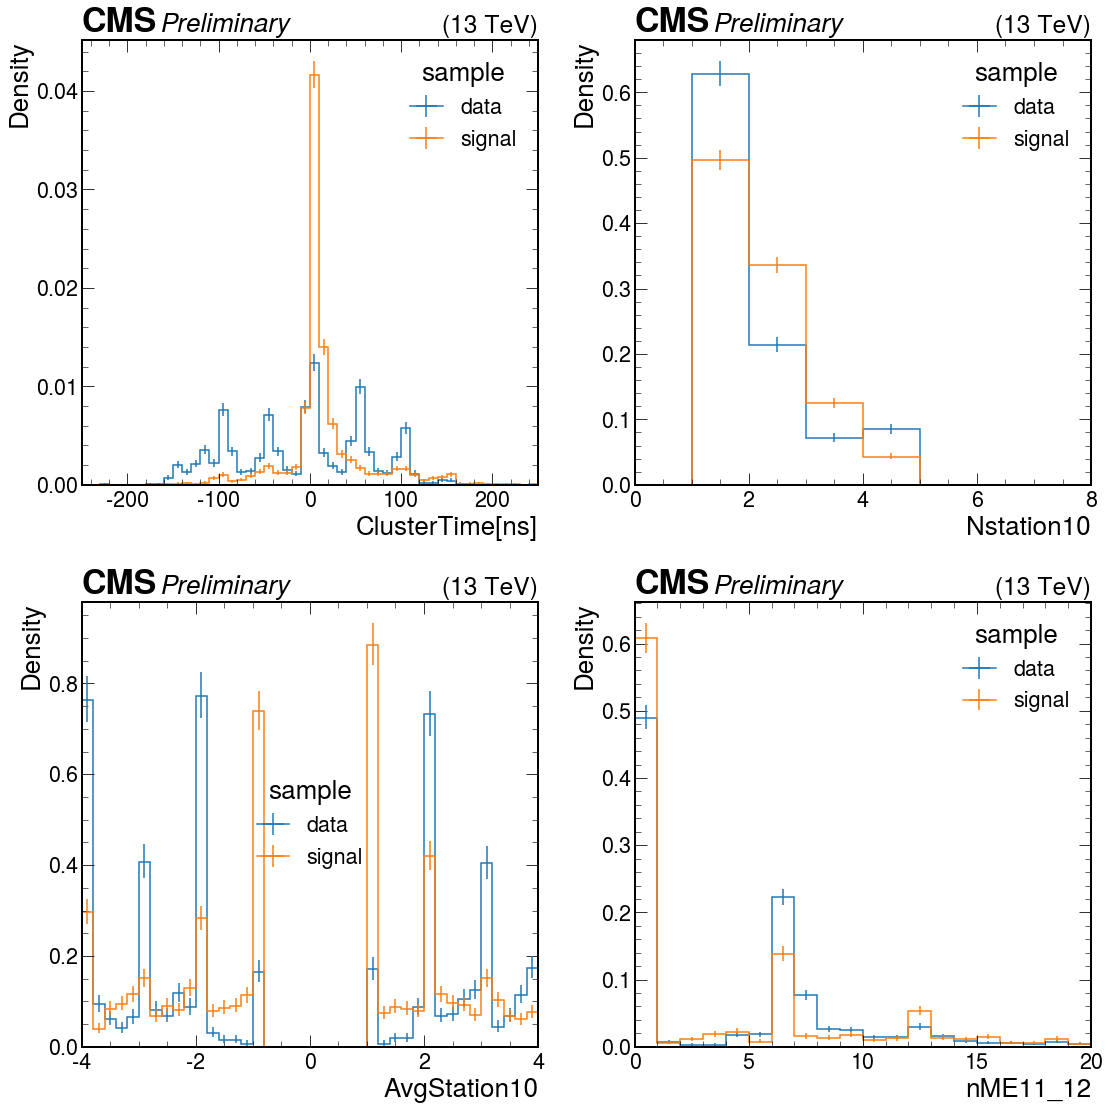

In [54]:
plt.style.use(hep.style.CMS)  
fig, axs = plt.subplots(2,2,figsize=(16,16))

axs = axs.flatten()
h1= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("Time", 'ClusterTime[ns]',50, -250, 250))                        
h2= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("nStation10", "Nstation10", 8, 0, 8))    
h3= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("avgStation10", "AvgStation10", 40, -4, 4))             
h4= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("nME11_12", "nME11_12", 20, 0, 20))             

for sample in samples:
    cls = sample['cls']
    label = sample['label']
    h1.fill(sample=label ,Time = ak.flatten(cls.Time))
    h2.fill(sample=label ,nStation10 = ak.flatten(cls.nStation10))
    h3.fill(sample=label ,avgStation10 = ak.flatten(cls.avgStation10))   
    h4.fill(sample=label ,nME11_12 = ak.flatten(cls.nME11_12))       
    
    

hist.plot1d(h1,density=density,ax=axs[0])    
hist.plot1d(h2,density=density,ax=axs[1])
hist.plot1d(h3,density=density,ax=axs[2])
hist.plot1d(h4,density=density,ax=axs[3])

for ax in axs:
    
    hep.cms.label(ax=ax,data=True,label="Preliminary")        
    if density: ax.set_ylabel("Density")
plt.tight_layout()


# Cluster ID

In [52]:
h= hist.Hist("Events",
              hist.Bin("nStation10", "Nstation10", 8, 0, 8),
              hist.Bin("eta", r"$\eta$", 40, -4, 4)
             )    
h.fill(nStation10=ak.flatten(d_cls.nStation10),
      eta = ak.flatten(d_cls.Eta))
h_group = h.group("nStation10",hist.Cat("nStationGrp","nStationGrp"),
                 {
                     "nStation=1":slice(0,2),
                     "nStation>=1":slice(2,None),                     
                 })

<AxesSubplot:xlabel='$\\eta$', ylabel='Events'>

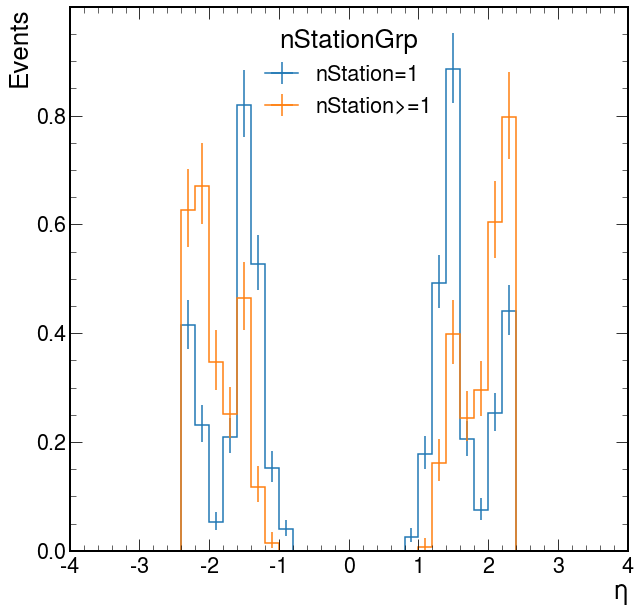

In [55]:
hist.plot1d(h_group,density=True)

(ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f3893164a30>, cbar=None, text=[]),
 [StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f389301abe0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)],
 [StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f3893035a00>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)])

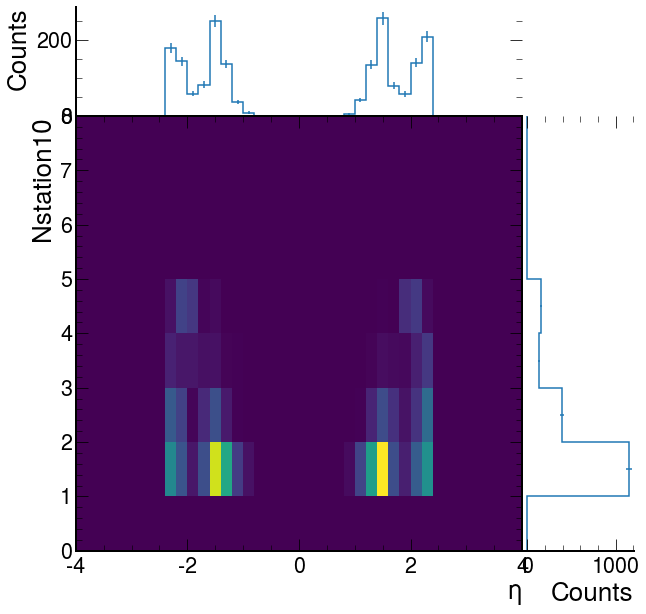

In [47]:
h.to_hist().project("eta","nStation10").plot2d_full()